# High-throughput Full-Length Single-Cell RNA-Seq Automation 
## Abstract

Existing protocols for full-length single-cell RNA sequencing (scRNA-seq) produce libraries of high complexity (thousands of distinct genes) with outstanding sensitivity and specificity of transcript quantification. These full-length libraries have the advantage of allowing probing of transcript isoforms, are informative regarding single nucleotide polymorphisms, and allow assembly of the VDJ region of the T- and B-cell receptor sequences. Since full length protocols are mostly plate-based at present, they are also suited to profiling cell types where cell numbers are limiting, such as rare cell types during development for instance. A disadvantage of these methods has been the scalability and cost of the experiments, which has limited their popularity as compared to droplet-based and nanowell approaches. Here, we describe an automated protocol for full-length scRNA-seq, including both an in-house automated SMART-seq2 protocol, and a commercial kit-based workflow. We discuss these two protocols in terms of ease-of-use, equipment requirements, running time, cost per sample and sequencing quality. By benchmarking the lysis buffers, reverse transcription enzymes and their combinations, we propose an optimized in-house automated protocol with dramatically reduced cost. These pipelines have been employed successfully for several research projects allied with the Human Cell Atlas initiative (www.humancellatlas.org) and are available on protocols.io.

This notebook includes all the codes to reproduce the figures in the paper. 

In [1]:
%pylab inline

import warnings
warnings.filterwarnings("ignore")
from SCQUA import *
from readquant import *
from glob import iglob

import scanpy as sc
import scipy

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_genebodycoverage(ad, ax=None, dropzero = True, colors = None, names = None, rel = True, n_min = 15000):
    df = pd.DataFrame(ad.obsm['genebodycoverage'])
    df.index = ad.obs_names
    if dropzero:
        df = df.loc[df.sum(1)>n_min,:]

    if rel:
        df1 = df.copy().div(df.sum(1),0)
    else:
        df1 = df.copy()
    df1['Protocol'] = ad.obs['Protocol']
    dd = df1['Protocol'].value_counts().to_dict()

    if colors is None:
        colors = [matplotlib.colors.rgb2hex(plt.get_cmap("tab10")(i)) for i in range(len(df1['Protocol'].unique()))]
    if names is None:
        names = df1['Protocol'].unique()
    colormap = dict(zip(names,colors))

#     fig, ax = plt.subplots()
    # sns.axes_style("darkgrid")
    epochs = np.arange(df.shape[1])+1
    for i in ad.obs['Protocol'].unique():
        m0 = df1.groupby('Protocol').mean().loc[i]
        m1 = df1.groupby('Protocol').max().loc[i]
        m2 = df1.groupby('Protocol').min().loc[i]
        label = '%s %d'%(i, (df1['Protocol'] == i).sum())
        ax.plot(epochs, m0, label=label,c = colormap[i])
        ax.fill_between(epochs, m2, m1 ,alpha=0.3, facecolor=colormap[i])
    ax.legend(bbox_to_anchor=(1, 1.15), ncol=2, fontsize=10)
    ax.set_xlabel('length %', fontsize=18)
    ax.set_ylabel('density', fontsize=18)
    return ax

In [3]:
def plot_jitter(df, ax=None, key1 = "detection_limit", key2 = "lane", ylog = False, xlabel = None, ylabel = None, palette=None):
	ax = sns.violinplot(x=key2,y=key1,data=df,inner=None, color=".9", cut=0, ax=ax)
	if ylog: ax.set_yscale("log", nonposy='clip')
	ax = sns.stripplot(x=key2,y=key1,data=df, jitter=0.3, palette=palette, ax=ax)
	ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
	if xlabel is None: xlabel = key2
	if ylabel is None: ylabel = key1
	sns.despine()
	ax.set_xlabel(xlabel, fontsize=18)
	ax.set_ylabel(ylabel, fontsize=18);
	return(ax)

In [4]:
# def fit_sensitivity_fig(df, ax=None, fun = 'np.log10(detection_limit)',key1 = "detection_limit", key2 = "n_counts", key3 = "protocol", \
# 					names = None, xlabel = None, ylabel = None,\
# 					xscale = 'log', yscale=None, \
# 					xlim = None, ylim = None, \
# 					xlabelsize = None, ylabelsize = None, \
# 					title = None, titlesize = None, \
# 					colors = None, colordots = False, \
# 					save = None):
# 	formula = '%s ~ np.power(np.log10(%s), 2) + np.log10(%s) + C(%s) + 1'%(fun,key2,key2,key3)
# 	mod = smf.ols(formula=formula, data=df)
# 	res = mod.fit()
# 	read_satureation = 10 ** (res.params['np.log10(%s)'%key2] / (-2 * res.params['np.power(np.log10(%s), 2)'%key2]))
	
# 	normalised_sensitivity = pd.Series()
# 	for protocol in df[key3].unique():
# 		normalised_sensitivity[protocol] = 10 ** res.predict(pd.DataFrame({key2: [1e6], key3: [protocol]}))
# 	if names is None:
# 		names = normalised_sensitivity.index
# 	if colors is None:
# 		colors = [matplotlib.colors.rgb2hex(plt.get_cmap("Paired")(i)) for i in range(len(names))]
	
# 	xx=np.logspace(3, np.log10(read_satureation), 50)
# 	pdf = pd.DataFrame({key2: xx})
	
# 	if not xscale is None:
# 		ax.set_xscale(xscale)
# 	if not yscale is None:
# 		ax.set_yscale(yscale)
	
# 	ax.scatter(df[key2], df[key1], c='#BBBBBB', edgecolor='none', s=50, label=None, rasterized=True);

# 	for i, protocol in enumerate(names):
# 		pdf[key3] = protocol
# 		if fun.startswith("np.log"):
# 			yy = 10 ** res.predict(pdf)
# 		else:
# 			yy = res.predict(pdf)
# 		xx2 = np.concatenate((xx, np.array([1e8])))
# 		yy2 = np.append(yy,yy.iloc[-1])
# 		ax.plot(xx2, yy2, label=protocol, color = colors[i])
# 		if colordots:
# 			ax.scatter(df.loc[df[key3] == protocol][key2], df.loc[df[key3] == protocol][key1], c=colors[i], edgecolor='none', s=50, label=None, rasterized=True);
		
# 	ax.axvline(xx[-1], linestyle='--', c='r', lw=1)
# 	for x in [1e4, 1e5, 1e6]:
# 		ax.axvline(x, linestyle='--', c='grey', lw=1)

# 	lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

# 	sns.despine()
# 	if xlabel is None: xlabel = key2
# 	if ylabel is None: ylabel = key1
# 	if xlabelsize is None:
# 		ax.set_xlabel(xlabel)
# 	else:
# 		ax.set_xlabel(xlabel, fontsize=xlabelsize)
# 	if ylabelsize is None:
# 		ax.set_ylabel(ylabel)
# 	else:
# 		ax.set_ylabel(ylabel, fontsize=ylabelsize)
	
# 	if not xlim is None:
# 		ax.set_xlim(xlim)
# 	if not ylim is None:
# 		ax.set_ylim(ylim)
# 	if not title is None:
# 		if titlesize is None:
# 			ax.set_title(title)
# 		else:
# 			ax.set_title(title, fontsize = titlesize)
# 	return ax

## Figure 2 and FigS3

In [5]:
ad = sc.read("anndata.h5")

In [6]:
ad = ad[(ad.obs['lane'].str.startswith('31617')|ad.obs['lane'].str.startswith('27921_6')),:]

In [8]:
ad.obs.groupby(['Enzyme','Buffer']).count()['num_processed']

Enzyme  Buffer
Maxima  RLT       288
        Triton    285
SMT     RLT       288
        Triton    288
Name: num_processed, dtype: int64

In [9]:
ad.obs['Protocol'] = ad.obs['Buffer'].astype(str)+'_'+ad.obs['Enzyme'].astype(str)

In [10]:
ad.obs['Protocol'].value_counts().index.tolist()

['RLT_SMT', 'RLT_Maxima', 'Triton_SMT', 'Triton_Maxima']

In [11]:
dd = dict(zip(ad.obs_names,ad.obs['Protocol']))
ds = pd.read_csv("downsample.csv", index_col=0)
ds = ds[ds['name'].isin(ad.obs_names)]
ds['Protocol'] = ds['name'].map(dd)

names = ['Triton_Maxima','Triton_SMT','RLT_Maxima', 'RLT_SMT',]
# https://www.color-hex.com/color-palette/83213
colors = ['#1F78B4','#FF7F00','#A6CEE3','#FDBF6F']
# colors = ['#1F78B4','#FF7F00']
df1=ds.replace([np.inf, -np.inf], np.nan).dropna(axis=0, subset=['detection_limit_ERCC', 'num_processed','Protocol'])
df1['num_processed'] = df1['num_processed'].astype(int)

In [12]:
from matplotlib.patches import Rectangle
def panel_a(ax):
    xx = 0
    yy = 0
    for i in range(12):
        for j in range(8):
            ax.plot(xx+i,yy+j, 'ko', markersize=8, markerfacecolor='w',\
             markeredgewidth=1.5, markeredgecolor='#000000')
    for i, j in enumerate(list('HGFEDCBA')):
        ax.text(xx-1.3,yy+i-0.5,j,fontsize=10)
    for i, j in enumerate(list('123456789')+['10','11','12']):
        ax.text(xx+i-0.3,yy+7.5,j,fontsize=8)
    rect = Rectangle((xx-1.2,yy-0.8), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    rect = Rectangle((xx-1.5,yy-0.5), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    
    xx = 15
    for i in range(12):
        for j in range(8):
            ax.plot(xx+i,yy+j, 'ko', markersize=8, markerfacecolor='w',\
             markeredgewidth=1.5, markeredgecolor='#000000')
    for i, j in enumerate(list('HGFEDCBA')):
        ax.text(xx-1.3,yy+i-0.5,j,fontsize=10)
    for i, j in enumerate(list('123456789')+['10','11','12']):
        ax.text(xx+i-0.3,yy+7.5,j,fontsize=8)
    rect = Rectangle((xx-1.2,yy-0.8), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    rect = Rectangle((xx-1.5,yy-0.5), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    
    xx = 32
    for i in range(12):
        for j in range(8):
            ax.plot(xx+i,yy+j, 'ko', markersize=8, markerfacecolor='w',\
             markeredgewidth=1.5, markeredgecolor='#000000')
    for i, j in enumerate(list('HGFEDCBA')):
        ax.text(xx-1.3,yy+i-0.5,j,fontsize=10)
    for i, j in enumerate(list('123456789')+['10','11','12']):
        ax.text(xx+i-0.3,yy+7.5,j,fontsize=8)
    rect = Rectangle((xx-1.2,yy-0.8), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    rect = Rectangle((xx-1.5,yy-0.5), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    
    xx = 47
    for i in range(12):
        for j in range(8):
            ax.plot(xx+i,yy+j, 'ko', markersize=8, markerfacecolor='w',\
             markeredgewidth=1.5, markeredgecolor='#000000')
    for i, j in enumerate(list('HGFEDCBA')):
        ax.text(xx-1.3,yy+i-0.5,j,fontsize=10)
    for i, j in enumerate(list('123456789')+['10','11','12']):
        ax.text(xx+i-0.3,yy+7.5,j,fontsize=8)
    rect = Rectangle((xx-1.2,yy-0.8), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    rect = Rectangle((xx-1.5,yy-0.5), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    
    xx = 0
    yy = 20
    for i in range(12):
        for j in range(8):
            ax.plot(xx+i,yy+j, 'ko', markersize=8, markerfacecolor='w',\
             markeredgewidth=1.5, markeredgecolor='#000000')
    for i, j in enumerate(list('HGFEDCBA')):
        ax.text(xx-1.3,yy+i-0.5,j,fontsize=10)
    for i, j in enumerate(list('123456789')+['10','11','12']):
        ax.text(xx+i-0.3,yy+7.5,j,fontsize=8)
    rect = Rectangle((xx-1.2,yy-0.8), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    rect = Rectangle((xx-1.5,yy-0.5), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    
    xx = 15
    for i in range(12):
        for j in range(8):
            ax.plot(xx+i,yy+j, 'ko', markersize=8, markerfacecolor='w',\
             markeredgewidth=1.5, markeredgecolor='#000000')
    for i, j in enumerate(list('HGFEDCBA')):
        ax.text(xx-1.3,yy+i-0.5,j,fontsize=10)
    for i, j in enumerate(list('123456789')+['10','11','12']):
        ax.text(xx+i-0.3,yy+7.5,j,fontsize=8)
    rect = Rectangle((xx-1.2,yy-0.8), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    rect = Rectangle((xx-1.5,yy-0.5), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    
    xx = 32
    for i in range(12):
        for j in range(8):
            ax.plot(xx+i,yy+j, 'ko', markersize=8, markerfacecolor='w',\
             markeredgewidth=1.5, markeredgecolor='#000000')
    for i, j in enumerate(list('HGFEDCBA')):
        ax.text(xx-1.3,yy+i-0.5,j,fontsize=10)
    for i, j in enumerate(list('123456789')+['10','11','12']):
        ax.text(xx+i-0.3,yy+7.5,j,fontsize=8)
    rect = Rectangle((xx-1.2,yy-0.8), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    rect = Rectangle((xx-1.5,yy-0.5), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    
    xx = 47
    for i in range(12):
        for j in range(8):
            ax.plot(xx+i,yy+j, 'ko', markersize=8, markerfacecolor='w',\
             markeredgewidth=1.5, markeredgecolor='#000000')
    for i, j in enumerate(list('HGFEDCBA')):
        ax.text(xx-1.3,yy+i-0.5,j,fontsize=10)
    for i, j in enumerate(list('123456789')+['10','11','12']):
        ax.text(xx+i-0.3,yy+7.5,j,fontsize=8)
    rect = Rectangle((xx-1.2,yy-0.8), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    rect = Rectangle((xx-1.5,yy-0.5), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    
    ax.annotate('Triton+ERCC', xy=(12.8, 30), xytext=(12.8, 31), 
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=10.0, lengthB=1.5', lw=2.0))
    ax.annotate('RLT+ERCC', xy=(44.5, 30), xytext=(44.5, 31), 
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=10.0, lengthB=1.5', lw=2.0))
    
    ax.annotate('Nextera cDNA library preparation', xy=(28.8, -2), xytext=(28.8, -5), 
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15.7, lengthA=-1.5', lw=2.0))
    
    ax.annotate('Splenocytes FACS sorting', xy=(12.8, 34), xytext=(28.8, 40), 
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.annotate('Splenocytes FACS sorting', xy=(44.5, 34), xytext=(28.8, 40), 
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.annotate('Nextera cDNA library preparation', xy=(28.8, -12), xytext=(28.8, -5),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.annotate('Illumina HiSeq4000', xy=(28.8, -10), xytext=(28.8, -15),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
    
    ax.annotate('Tissue dissociation', xy=(28.8, 42), xytext=(28.8, 50),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.annotate(' ', xy=(28.8, 52), xytext=(28.8, 60),  
            fontsize=16, ha='center', va='bottom',
            arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.annotate('Maxima', xy=(5, 10), xytext=(5, 10),  
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
    ax.annotate('SMT', xy=(20, 10), xytext=(20, 10),  
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
    ax.annotate('Maxima', xy=(38, 10), xytext=(38, 10),  
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
    ax.annotate('SMT', xy=(52, 10), xytext=(52, 10),  
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
    
    ax.annotate('', xy=(5, 13), xytext=(5, 19),  
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('', xy=(20, 13), xytext=(20, 19),  
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('', xy=(38, 13), xytext=(38, 19),  
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('', xy=(52, 13), xytext=(52, 19),  
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.set_xlim([-3, 60])
    ax.set_ylim([-17,63])
    ax.axis('off')
    return ax

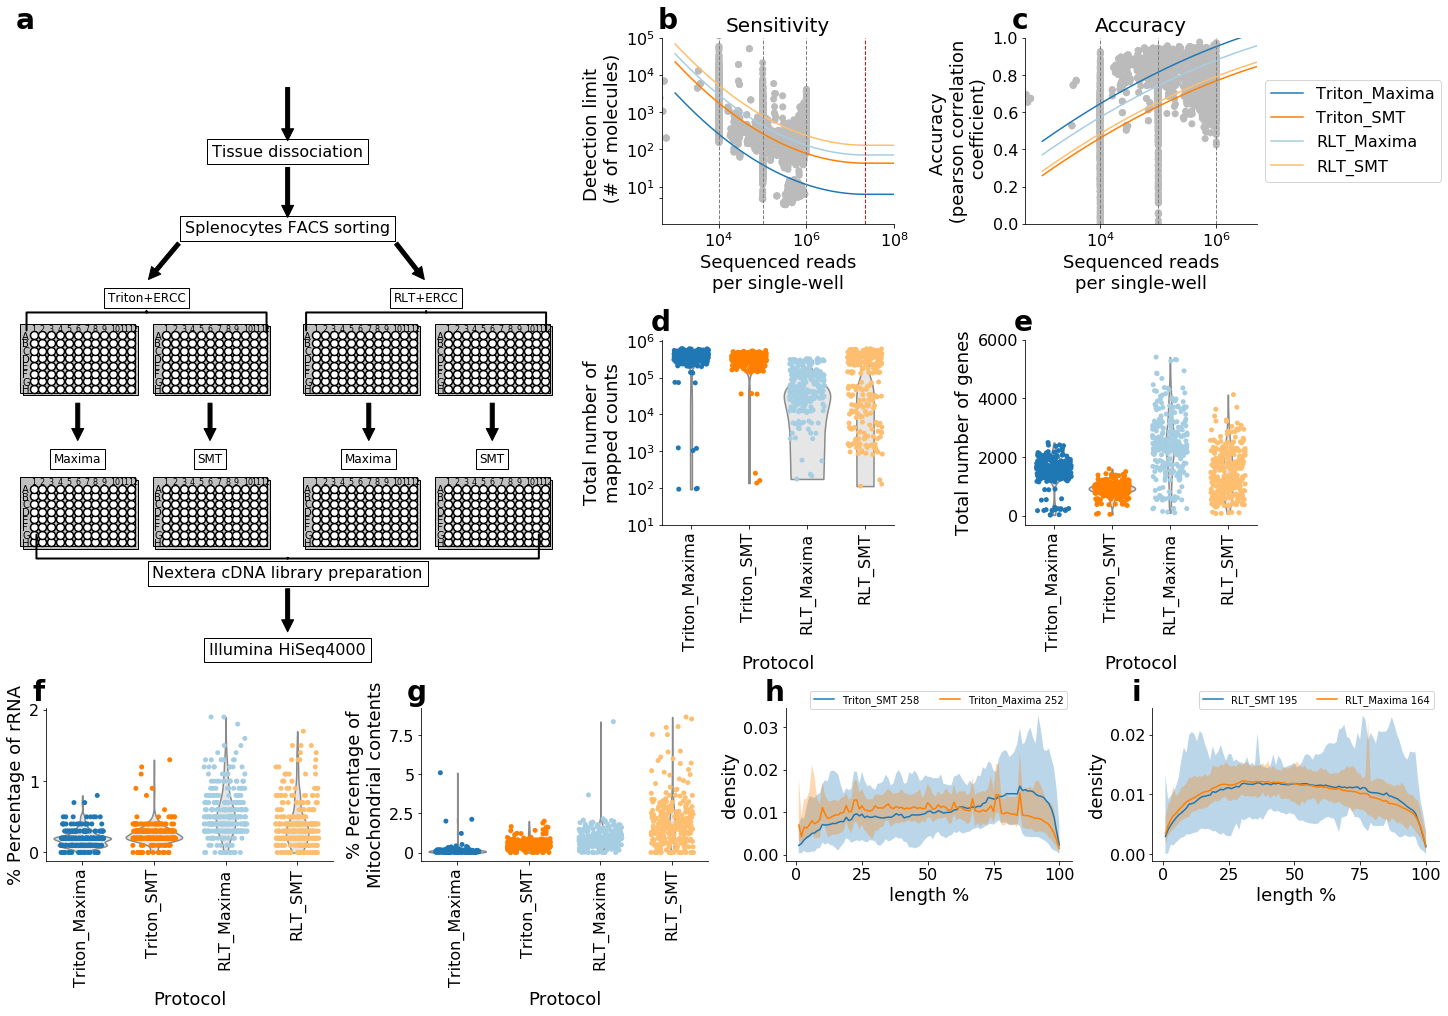

In [13]:
figsize(20,14)
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(constrained_layout=True)
# gs = GridSpec(3, 5, figure=fig)
# ax1 = fig.add_subplot(gs[:2, :2])
# ax2 = fig.add_subplot(gs[0, 2])
# ax3 = fig.add_subplot(gs[0, 3])
# ax4 = fig.add_subplot(gs[1, 2])
# ax5 = fig.add_subplot(gs[1, 3])

# ax6 = fig.add_subplot(gs[2, 0])
# ax7 = fig.add_subplot(gs[2, 1])
# ax8 = fig.add_subplot(gs[2, 2])
# ax9 = fig.add_subplot(gs[2, 3])

gs = GridSpec(2, 1, figure=fig, height_ratios=[2, 1])
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[2,3])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1])
gs3 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs1[1])

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs3[0, 0])
ax3 = fig.add_subplot(gs3[0, 1])
ax4 = fig.add_subplot(gs3[1, 0])
ax5 = fig.add_subplot(gs3[1, 1])

ax6 = fig.add_subplot(gs2[0, 0])
ax7 = fig.add_subplot(gs2[0, 1])
ax8 = fig.add_subplot(gs2[0, 2])
ax9 = fig.add_subplot(gs2[0, 3])


ax1 = panel_a(ax1)

ax2 = fit_sensitivity_fig(df1,ax=ax2, fun = 'np.log10(detection_limit_ERCC)', key1 = "detection_limit_ERCC", key2="num_processed",key3='Protocol', \
                     yscale='log', xlabel = 'Sequenced reads\nper single-well',\
                     ylabel = 'Detection limit \n (# of molecules)', \
                     ylim = [1, 1e5], xlim = [500, 1e8], \
                     xlabelsize = 18, ylabelsize = 18, \
                     title = 'Sensitivity', titlesize = 20, names = names, colors=colors)
ax2.get_legend().remove()
ax2.set_yticks([5, 10, 100, 1000, 10000, 100000])
ax3 = fit_sensitivity_fig(df1, ax=ax3, fun = 'accuracy_ERCC',key1="accuracy_ERCC",key2="num_processed",key3='Protocol', \
                     xlabel = 'Sequenced reads\nper single-well',\
                     ylabel = 'Accuracy \n (pearson correlation \n coefficient)', \
                     ylim = [0, 1], xlim = [500, 5e6], \
                     xlabelsize = 18, ylabelsize = 18, \
                     title = 'Accuracy', titlesize = 20, names = names, colors=colors)
# ax3.get_legend().remove()

df2=ad.obs.replace([np.inf, -np.inf], np.nan).dropna(axis=0, subset=['detection_limit_ERCC', 'num_processed','Protocol'])
df2['num_processed'] = df2['num_processed'].astype(int)
df2['Protocol'] = df2['Protocol'].astype('category')
df2['Protocol'] = df2['Protocol'].cat.reorder_categories(names)

ax4 = plot_jitter(df2, ax=ax4, key1 = "n_counts", key2 = "Protocol", ylog=True, \
            ylabel='Total number of\nmapped counts', palette=colors)
ax4.set_yticks([10, 100, 1000, 10000, 100000, 1e6])
ax5 = plot_jitter(df2, ax=ax5, key1 = "n_genes", key2 = "Protocol", ylog=False, \
            ylabel='Total number of genes', palette=colors)
ax5.set_yticks([0, 2000, 4000, 6000])
df2['rRNA%'] = df2['rRNA%'].astype(float)
ax6 = plot_jitter(df2, ax=ax6, key1 = "rRNA%", key2 = "Protocol", ylabel='% Percentage of rRNA', palette=colors)

# ax7 = plot_jitter(df2, ax=ax7, key1 = "exonic", key2 = "Protocol",\
#             ylabel='% Percentage of\nreads mapped to\nthe exonic regions', palette=colors)
ax7 = plot_jitter(df2, ax=ax7, key1 = "percent_mito", key2 = "Protocol", \
            ylabel='% Percentage of\nMitochondrial contents', palette=colors)

ad1 = ad[ad.obs['Protocol'].str.startswith('Triton'),:]
ax8 = plot_genebodycoverage(ad=ad1, ax=ax8, colors=colors)

ad2 = ad[ad.obs['Protocol'].str.startswith('RLT'),:]
ax9 = plot_genebodycoverage(ad=ad2, ax=ax9, colors=colors)

# ax8.get_legend().remove()
# ax9.get_legend().remove()

ax1.annotate('a', (-2,1.05), size=28, xycoords=ax1.get_xaxis_transform(), weight='bold')
ax2.annotate('b', (400,1.05), size=28, xycoords=ax2.get_xaxis_transform(), weight='bold')
ax3.annotate('c', (300,1.05), size=28, xycoords=ax3.get_xaxis_transform(), weight='bold')

ax4.annotate('d', (-0.7,1.05), size=28, xycoords=ax4.get_xaxis_transform(), weight='bold')
ax5.annotate('e', (-0.7,1.05), size=28, xycoords=ax5.get_xaxis_transform(), weight='bold')

ax6.annotate('f', (-0.7,1.05), size=28, xycoords=ax6.get_xaxis_transform(), weight='bold')
ax7.annotate('g', (-0.7,1.05), size=28, xycoords=ax7.get_xaxis_transform(), weight='bold')
ax7.set_yticklabels([0,0,2.5,5,7.5])
ax8.annotate('h', (-12,1.05), size=28, xycoords=ax8.get_xaxis_transform(), weight='bold')
ax9.annotate('i', (-12,1.05), size=28, xycoords=ax9.get_xaxis_transform(), weight='bold')

plt.savefig("Fig2.pdf")

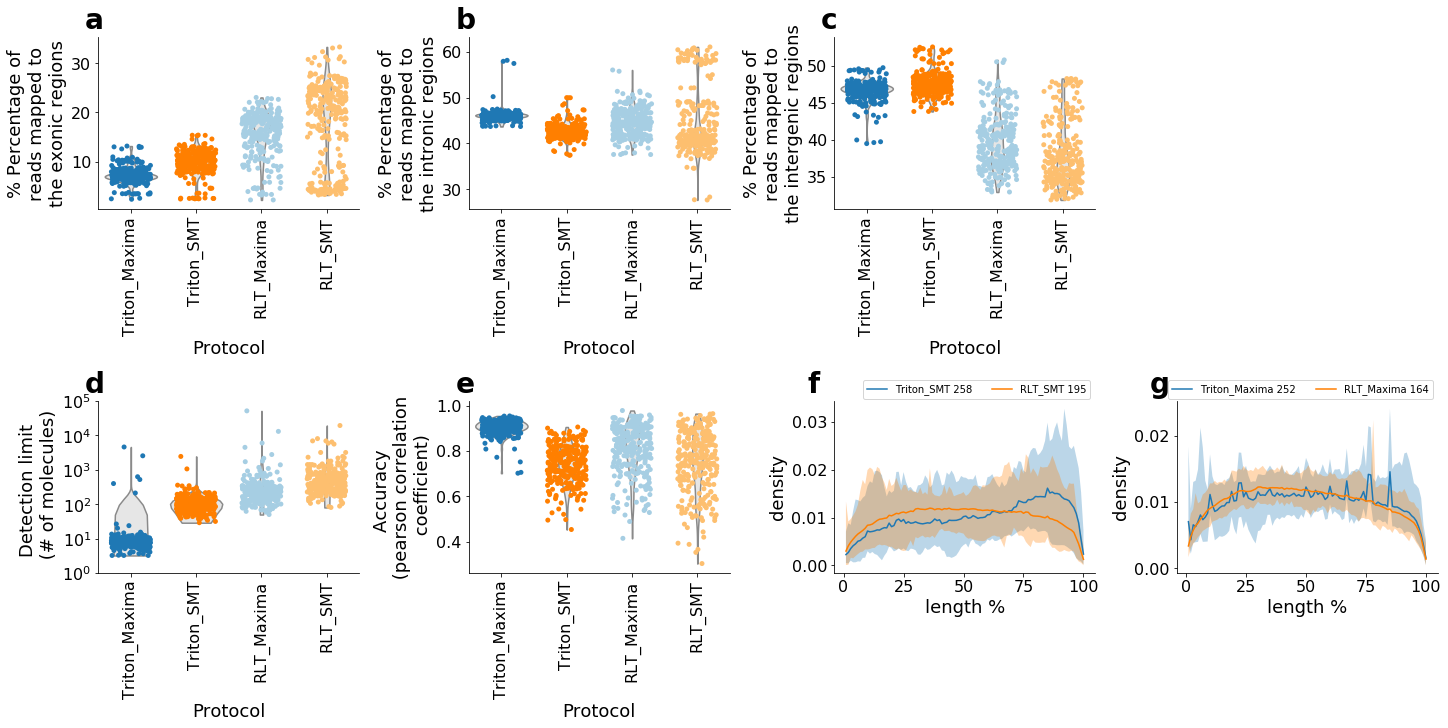

In [14]:
figsize(20,10)
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(constrained_layout=True)
gs = GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
# ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])

# ax1 = plot_jitter(df2, ax=ax1, key1 = "percent_mito", key2 = "Protocol", \
#             ylabel='% Percentage of\nMitochondrial contents', palette=colors)

ax1 = plot_jitter(df2, ax=ax1, key1 = "exonic", key2 = "Protocol",\
            ylabel='% Percentage of\nreads mapped to\nthe exonic regions', palette=colors)

ax2 = plot_jitter(df2, ax=ax2, key1 = "intronic", key2 = "Protocol", \
            ylabel='% Percentage of\nreads mapped to\nthe intronic regions', palette=colors)

ax3 = plot_jitter(df2, ax=ax3, key1 = "intergenic", key2 = "Protocol", \
            ylabel='% Percentage of\nreads mapped to\nthe intergenic regions', palette=colors)

ax5 = plot_jitter(df2, ax=ax5, key1 = "detection_limit_ERCC", key2 = "Protocol", \
            ylog=True, ylabel='Detection limit \n (# of molecules)', palette=colors)
ax5.set_yticks([1, 10, 100, 1000, 10000, 100000])
ax6 = plot_jitter(df2, ax=ax6, key1 = "accuracy_ERCC", key2 = "Protocol", \
            ylabel='Accuracy \n (pearson correlation \n coefficient)', palette=colors)

ad3 = ad[ad.obs['Protocol'].str.endswith('SMT'),:]
ax7 = plot_genebodycoverage(ad=ad3, ax=ax7, colors=colors)

ad4 = ad[ad.obs['Protocol'].str.endswith('Maxima'),:]
ax8 = plot_genebodycoverage(ad=ad4, ax=ax8, colors=colors)

ax1.annotate('a', (-0.7,1.05), size=28, xycoords=ax1.get_xaxis_transform(), weight='bold')
ax2.annotate('b', (-0.7,1.05), size=28, xycoords=ax2.get_xaxis_transform(), weight='bold')
ax3.annotate('c', (-0.7,1.05), size=28, xycoords=ax3.get_xaxis_transform(), weight='bold')
# ax4.annotate('d', (-0.7,1.05), size=28, xycoords=ax4.get_xaxis_transform(), weight='bold')
ax5.annotate('d', (-0.7,1.05), size=28, xycoords=ax5.get_xaxis_transform(), weight='bold')
ax6.annotate('e', (-0.7,1.05), size=28, xycoords=ax6.get_xaxis_transform(), weight='bold')
ax7.annotate('f', (-15,1.05), size=28, xycoords=ax7.get_xaxis_transform(), weight='bold')
ax8.annotate('g', (-15,1.05), size=28, xycoords=ax8.get_xaxis_transform(), weight='bold')

plt.savefig("FigS3.pdf")

In [15]:
df2

,num_processed,num_mapped,percent_mapped,global_fl_mode,robust_fl_mode,n_counts,n_genes,lane,detection_limit_ERCC,accuracy_ERCC,...,reads at junctions,exonic_no,intronic_no,intergenic_no,overlapping exon_no,percent_mito,ASE,Enzyme,Buffer,Protocol
index,,,,,,,,,,,,,,,,,,,,,
27921_6#100,387284,205038,52.94254345648155,137,137,205038.004,1114,27921_6,106.800651,0.805691,...,26969.0,122679.0,477942.0,498814.0,15781.0,0.006893,0.0,SMT,Triton,Triton_SMT
27921_6#101,671618,349364,52.018260380156576,96,106,349363.998,996,27921_6,69.665786,0.728930,...,44310.0,200007.0,871399.0,976975.0,24166.0,0.005250,0.0,SMT,Triton,Triton_SMT
27921_6#11,469628,233576,49.736387097873205,137,137,233575.995,922,27921_6,99.529423,0.798256,...,36861.0,166739.0,554431.0,638100.0,19152.0,0.005762,0.0,SMT,Triton,Triton_SMT
27921_6#1,287340,166648,57.99679821813879,134,134,166647.999,715,27921_6,62.317761,0.710325,...,12833.0,70444.0,392531.0,475543.0,9346.0,0.008162,0.0,SMT,Triton,Triton_SMT
27921_6#121,382603,206357,53.935018805393575,137,137,206357.002,878,27921_6,59.661887,0.717659,...,26859.0,126046.0,466689.0,536787.0,14029.0,0.004477,0.0,SMT,Triton,Triton_SMT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31617_2#95,494702,342593,69.2523984135904,137,137,342592.997,1417,31617_2,8.418905,0.932491,...,42327.0,137539.0,799801.0,813373.0,18864.0,0.000782,1.0,Maxima,Triton,Triton_Maxima
31617_2#99,589499,314972,53.43045535276565,137,137,314971.992,853,31617_2,140.957319,0.668539,...,42294.0,161293.0,759450.0,843211.0,17262.0,0.001888,1.0,SMT,Triton,Triton_SMT
31617_2#94,640703,452896,70.68735435919608,136,136,452895.999,1502,31617_2,9.428783,0.922609,...,42264.0,166567.0,1068466.0,1074826.0,23620.0,0.000881,0.0,Maxima,Triton,Triton_Maxima


In [17]:
df2.groupby('Protocol').max().to_csv("Fig2_max.csv")

In [18]:
df2.groupby('Protocol').min().to_csv("Fig2_min.csv")

In [21]:
df2.groupby('Protocol').median().to_csv("Fig2_median.csv")

In [ ]:
df2.groupby('Protocol').mean().to_csv("Fig2_mean.csv")

## Figure S4

In [9]:
ad = sc.read("anndata.h5")

In [10]:
ad = ad[((ad.obs['lane']=='24973_2')|(ad.obs['lane'].str.startswith('24380'))),:]

df = ad.obs['Enzyme']
df[ad.obs['lane'].str.startswith('24380')] = 'NEB'
ad.obs['Enzyme'] = df.tolist()

ds = ad.obs['Buffer'].astype(str)
ds.loc[ad.obs['lane'].str.startswith('24380')] = ad[ad.obs['lane'].str.startswith('24380')].obs['lane'].map({'24380_6':'mESC','24380_7':'Immune Cells Mix','24380_8':'CD4+'}).tolist()
ad.obs['Buffer'] = ds

Trying to set attribute `.obs` of view, copying.


In [11]:
ad.obs['Protocol'] = ad.obs['Buffer'].astype(str)+'_'+ad.obs['Enzyme'].astype(str)

In [13]:
ad = ad[~ad.obs['Protocol'].isin(['Immune Cells Mix_NEB']),:]
# ad = ad[~ad.obs['Protocol'].str.endswith('NEB'),:]

In [14]:
ad.obs['Protocol'].value_counts()

CD4+_NEB        193
mESC_NEB        192
mESC_SMARTER     96
CD4+_SMARTER     96
Name: Protocol, dtype: int64

In [13]:
ad.obs.groupby(['Enzyme','Buffer']).count()['num_processed']

Enzyme   Buffer
NEB      CD4+      193
         mESC      192
SMARTER  CD4+       96
         mESC       96
Name: num_processed, dtype: int64

In [14]:
ad.obs['Protocol'] = ad.obs['Buffer'].astype(str)+'_'+ad.obs['Enzyme'].astype(str)

In [15]:
ad.obs['Protocol'].value_counts().index.tolist()

['CD4+_NEB', 'mESC_NEB', 'CD4+_SMARTER', 'mESC_SMARTER']

In [16]:
from scanpy.plotting.palettes import *

In [17]:
dd = dict(zip(ad.obs_names,ad.obs['Protocol']))
ds = pd.read_csv("downsample.csv", index_col=0)
ds = ds[ds['name'].isin(ad.obs_names)]
ds['Protocol'] = ds['name'].map(dd)

names = ['CD4+_NEB', 'CD4+_SMARTER', 'mESC_NEB', 'mESC_SMARTER']
# https://www.color-hex.com/color-palette/83213
colors = default_20
# colors = ['#1F78B4','#FF7F00']
df1=ds.replace([np.inf, -np.inf], np.nan).dropna(axis=0, subset=['detection_limit_ERCC', 'num_processed','Protocol'])
df1['num_processed'] = df1['num_processed'].astype(int)

In [48]:
names = ['CD4+_NEB', 'mESC_NEB']

In [17]:
df1['detection_limit_ERCC'].min()

26.38562483505035

In [53]:
from matplotlib.patches import Rectangle
def panel_a(ax):
    xx = 0
    yy = 0
    for i in range(12):
        for j in range(8):
            ax.plot(xx+i,yy+j, 'ko', markersize=8, markerfacecolor='w',\
             markeredgewidth=1.5, markeredgecolor='#000000')
    for i, j in enumerate(list('HGFEDCBA')):
        ax.text(xx-1.3,yy+i-0.5,j,fontsize=10)
    for i, j in enumerate(list('123456789')+['10','11','12']):
        ax.text(xx+i-0.3,yy+7.5,j,fontsize=8)
    rect = Rectangle((xx-1.2,yy-0.8), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    rect = Rectangle((xx-1.5,yy-0.5), 13, 9, facecolor='#c0c0c0', edgecolor='k')
    ax.add_patch(rect)
    
    ax.annotate('CD45+ enrichment', xy=(5, 18), xytext=(18, 22),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('Tissue dissociation', xy=(18, 24), xytext=(18, 28),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('Spleen', xy=(18, 30), xytext=(18, 34),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))

    ax.annotate('mESC', xy=(5, 18), xytext=(-8, 22),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))

    
    
    ax.annotate('NEB lysis buffer with + ERCC', xy=(5, 9), xytext=(5, 10),  
            fontsize=14, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
    ax.annotate('FACS sorting', xy=(5, 12), xytext=(5, 16),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))

    ax.annotate('', xy=(5, -4.5), xytext=(5, -0.5),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('Reverse Transcription', xy=(5, -10), xytext=(5, -6),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('Nextera cDNA library prep', xy=(5, -16), xytext=(5, -12),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate('Illumina HiSeq4000', xy=(5, -18), xytext=(5, -18),  
            fontsize=16, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
    
    ax.set_xlim([-15, 25])
    ax.set_ylim([-20,40])
    ax.axis('off')
    return ax

Text(-12, 1.05, 'i')

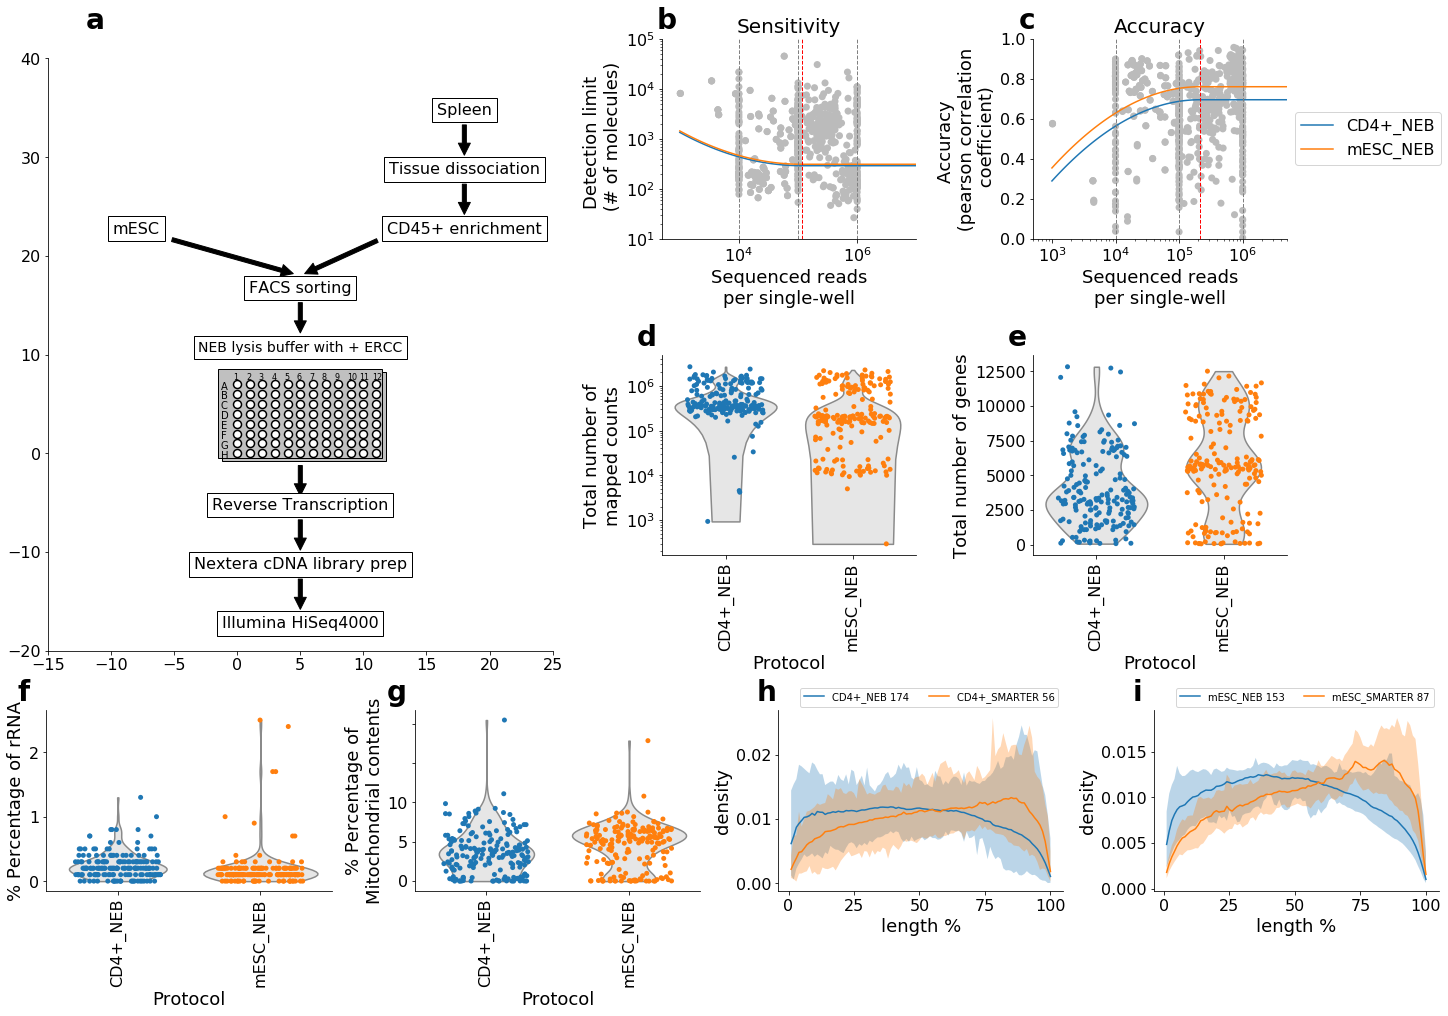

In [52]:
figsize(20,14)
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 1, figure=fig, height_ratios=[1, 1])
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[2,3])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1])
gs3 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs1[1])

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs3[0, 0])
ax3 = fig.add_subplot(gs3[0, 1])
ax4 = fig.add_subplot(gs3[1, 0])
ax5 = fig.add_subplot(gs3[1, 1])

ax6 = fig.add_subplot(gs2[0, 0])
ax7 = fig.add_subplot(gs2[0, 1])
ax8 = fig.add_subplot(gs2[0, 2])
ax9 = fig.add_subplot(gs2[0, 3])


ax1 = panel_a(ax1)
ax1.axis('off')
ax2 = fit_sensitivity_fig(df1,ax=ax2, fun = 'np.log10(detection_limit_ERCC)', key1 = "detection_limit_ERCC", key2="num_processed",key3='Protocol', \
                     yscale='log', xlabel = 'Sequenced reads\nper single-well',\
                     ylabel = 'Detection limit \n (# of molecules)', \
                     ylim = [10, 1e5], xlim = [500, 1e7], \
                     xlabelsize = 18, ylabelsize = 18, \
                     title = 'Sensitivity', titlesize = 20, names = names, colors=colors)
ax2.get_legend().remove()
ax2.set_yticks([10, 100, 1000, 10000, 100000])

ax3 = fit_sensitivity_fig(df1, ax=ax3, fun = 'accuracy_ERCC',key1="accuracy_ERCC",key2="num_processed",key3='Protocol', \
                     xlabel = 'Sequenced reads\nper single-well',\
                     ylabel = 'Accuracy \n (pearson correlation \n coefficient)', \
                     ylim = [0, 1], xlim = [500, 5e6], \
                     xlabelsize = 18, ylabelsize = 18, \
                     title = 'Accuracy', titlesize = 20, names = names, colors=colors)
# ax3.get_legend().remove()

df2=ad.obs.replace([np.inf, -np.inf], np.nan).dropna(axis=0, subset=['detection_limit_ERCC', 'num_processed','Protocol'])
df2['num_processed'] = df2['num_processed'].astype(int)
df2 = df2[df2['Protocol'].isin(names)]
df2['Protocol'] = df2['Protocol'].astype('category')
df2['Protocol'] = df2['Protocol'].cat.reorder_categories(names)

ax4 = plot_jitter(df2, ax=ax4, key1 = "n_counts", key2 = "Protocol", ylog=True, \
            ylabel='Total number of\nmapped counts', palette=colors)

ax5 = plot_jitter(df2, ax=ax5, key1 = "n_genes", key2 = "Protocol", ylog=False, \
            ylabel='Total number of genes', palette=colors)

df2['rRNA%'] = df2['rRNA%'].astype(float)
ax6 = plot_jitter(df2, ax=ax6, key1 = "rRNA%", key2 = "Protocol", ylabel='% Percentage of rRNA', palette=colors)

ax7 = plot_jitter(df2, ax=ax7, key1 = "percent_mito", key2 = "Protocol", \
            ylabel='% Percentage of\nMitochondrial contents', palette=colors)

ax8 = plot_jitter(df2, ax=ax8, key1 = "detection_limit_ERCC", key2 = "Protocol", \
            ylog=True, ylabel='Detection limit \n (# of molecules)', palette=colors)

ax9 = plot_jitter(df2, ax=ax9, key1 = "accuracy_ERCC", key2 = "Protocol", \
            ylabel='Accuracy \n (pearson correlation \n coefficient)', palette=colors)

ax10 = plot_jitter(df2, ax=ax10, key1 = "exonic", key2 = "Protocol",\
            ylabel='% Percentage of\nreads mapped to\nthe exonic regions', palette=colors)

ax11 = plot_jitter(df2, ax=ax11, key1 = "intronic", key2 = "Protocol", \
            ylabel='% Percentage of\nreads mapped to\nthe intronic regions', palette=colors)

ax12 = plot_jitter(df2, ax=ax12, key1 = "intergenic", key2 = "Protocol", \
            ylabel='% Percentage of\nreads mapped to\nthe intergenic regions', palette=colors)

ad2 = ad[ad.obs['Protocol'].str.endswith('NEB'),:]
ax13 = plot_genebodycoverage(ad=ad2, ax=ax13, colors=colors)

# ax8.get_legend().remove()
# ax9.get_legend().remove()

ax1.annotate('a', (-12,1.05), size=28, xycoords=ax1.get_xaxis_transform(), weight='bold')
ax2.annotate('b', (400,1.05), size=28, xycoords=ax2.get_xaxis_transform(), weight='bold')

ax3.annotate('c', (300,1.05), size=28, xycoords=ax3.get_xaxis_transform(), weight='bold')

ax4.annotate('d', (-0.7,1.05), size=28, xycoords=ax4.get_xaxis_transform(), weight='bold')
ax5.annotate('e', (-0.7,1.05), size=28, xycoords=ax5.get_xaxis_transform(), weight='bold')

ax6.annotate('f', (-0.7,1.05), size=28, xycoords=ax6.get_xaxis_transform(), weight='bold')
ax7.annotate('g', (-0.7,1.05), size=28, xycoords=ax7.get_xaxis_transform(), weight='bold')
ax8.annotate('h', (-12,1.05), size=28, xycoords=ax8.get_xaxis_transform(), weight='bold')
ax9.annotate('i', (-12,1.05), size=28, xycoords=ax9.get_xaxis_transform(), weight='bold')

plt.savefig("FigS4.pdf")

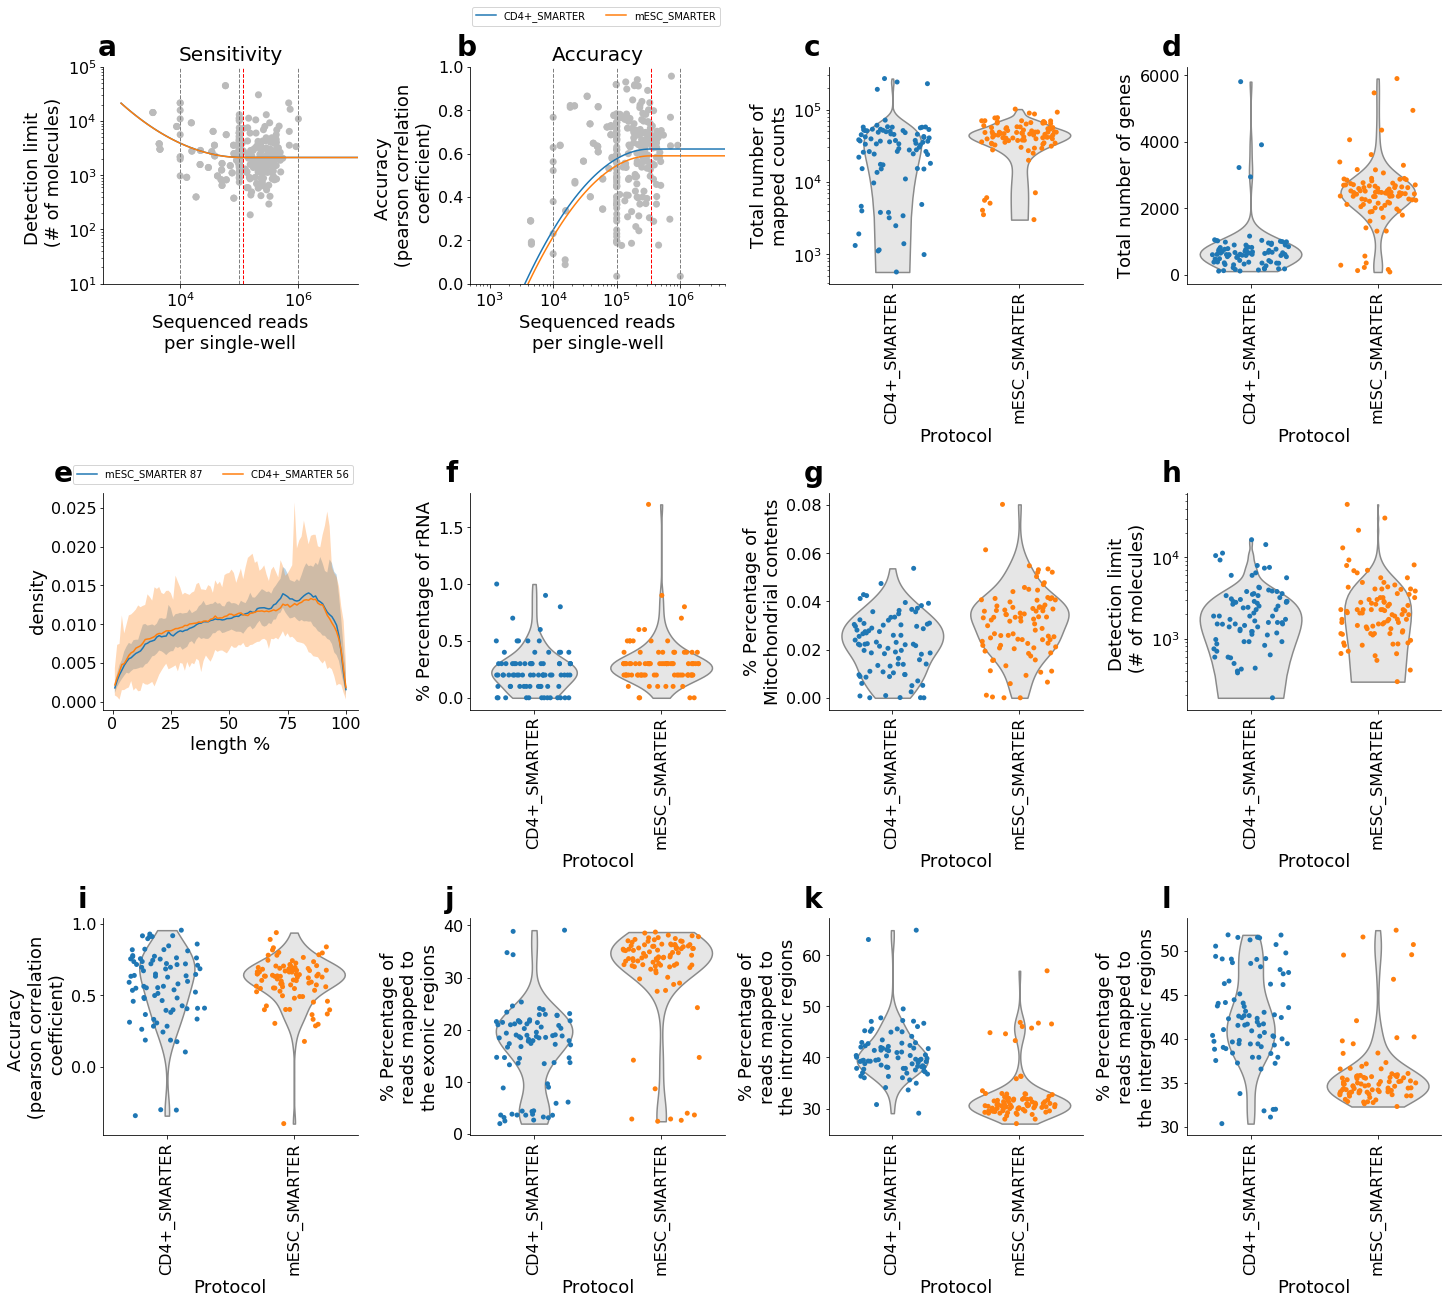

In [44]:
figsize(20,18)
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(constrained_layout=True)
gs = GridSpec(3, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])
ax9 = fig.add_subplot(gs[2, 0])
ax10 = fig.add_subplot(gs[2, 1])
ax11 = fig.add_subplot(gs[2, 2])
ax12 = fig.add_subplot(gs[2, 3])

ax1 = fit_sensitivity_fig(df1,ax=ax1, fun = 'np.log10(detection_limit_ERCC)', key1 = "detection_limit_ERCC", key2="num_processed",key3='Protocol', \
                     yscale='log', xlabel = 'Sequenced reads\nper single-well',\
                     ylabel = 'Detection limit \n (# of molecules)', \
                     ylim = [10, 1e5], xlim = [500, 1e7], \
                     xlabelsize = 18, ylabelsize = 18, \
                     title = 'Sensitivity', titlesize = 20, names = names, colors=colors)
ax1.get_legend().remove()
ax1.set_yticks([10, 100, 1000, 10000, 100000])

ax2 = fit_sensitivity_fig(df1, ax=ax2, fun = 'accuracy_ERCC',key1="accuracy_ERCC",key2="num_processed",key3='Protocol', \
                     xlabel = 'Sequenced reads\nper single-well',\
                     ylabel = 'Accuracy \n (pearson correlation \n coefficient)', \
                     ylim = [0, 1], xlim = [500, 5e6], \
                     xlabelsize = 18, ylabelsize = 18, \
                     title = 'Accuracy', titlesize = 20, names = names, colors=colors)
ax2.legend(bbox_to_anchor=(1, 1.3), ncol=2, fontsize=10)

df2=ad.obs.replace([np.inf, -np.inf], np.nan).dropna(axis=0, subset=['detection_limit_ERCC', 'num_processed','Protocol'])
df2['num_processed'] = df2['num_processed'].astype(int)
df2['Protocol'] = df2['Protocol'].astype('category')
df2['Protocol'] = df2['Protocol'].cat.reorder_categories(names)

ax3 = plot_jitter(df2, ax=ax3, key1 = "n_counts", key2 = "Protocol", ylog=True, \
            ylabel='Total number of\nmapped counts', palette=colors)

ax4 = plot_jitter(df2, ax=ax4, key1 = "n_genes", key2 = "Protocol", ylog=False, \
            ylabel='Total number of genes', palette=colors)

ax5 = plot_genebodycoverage(ad=ad, ax=ax5, colors=colors)

df2['rRNA%'] = df2['rRNA%'].astype(float)
ax6 = plot_jitter(df2, ax=ax6, key1 = "rRNA%", key2 = "Protocol", ylabel='% Percentage of rRNA', palette=colors)

ax7 = plot_jitter(df2, ax=ax7, key1 = "percent_mito", key2 = "Protocol", \
            ylabel='% Percentage of\nMitochondrial contents', palette=colors)

ax8 = plot_jitter(df2, ax=ax8, key1 = "detection_limit_ERCC", key2 = "Protocol", \
            ylog=True, ylabel='Detection limit \n (# of molecules)', palette=colors)

ax9 = plot_jitter(df2, ax=ax9, key1 = "accuracy_ERCC", key2 = "Protocol", \
            ylabel='Accuracy \n (pearson correlation \n coefficient)', palette=colors)

ax10 = plot_jitter(df2, ax=ax10, key1 = "exonic", key2 = "Protocol",\
            ylabel='% Percentage of\nreads mapped to\nthe exonic regions', palette=colors)

ax11 = plot_jitter(df2, ax=ax11, key1 = "intronic", key2 = "Protocol", \
            ylabel='% Percentage of\nreads mapped to\nthe intronic regions', palette=colors)

ax12 = plot_jitter(df2, ax=ax12, key1 = "intergenic", key2 = "Protocol", \
            ylabel='% Percentage of\nreads mapped to\nthe intergenic regions', palette=colors)

ax1.annotate('a', (400,1.05), size=28, xycoords=ax1.get_xaxis_transform(), weight='bold')
ax2.annotate('b', (300,1.05), size=28, xycoords=ax2.get_xaxis_transform(), weight='bold')
ax3.annotate('c', (-0.7,1.05), size=28, xycoords=ax3.get_xaxis_transform(), weight='bold')
ax4.annotate('d', (-0.7,1.05), size=28, xycoords=ax4.get_xaxis_transform(), weight='bold')

ax5.annotate('e', (-25,1.05), size=28, xycoords=ax5.get_xaxis_transform(), weight='bold')
ax6.annotate('f', (-0.7,1.05), size=28, xycoords=ax6.get_xaxis_transform(), weight='bold')
ax7.annotate('g', (-0.7,1.05), size=28, xycoords=ax7.get_xaxis_transform(), weight='bold')
ax8.annotate('h', (-0.7,1.05), size=28, xycoords=ax8.get_xaxis_transform(), weight='bold')

ax9.annotate('i', (-0.7,1.05), size=28, xycoords=ax9.get_xaxis_transform(), weight='bold')
ax10.annotate('j', (-0.7,1.05), size=28, xycoords=ax10.get_xaxis_transform(), weight='bold')
ax11.annotate('k', (-0.7,1.05), size=28, xycoords=ax11.get_xaxis_transform(), weight='bold')
ax12.annotate('l', (-0.7,1.05), size=28, xycoords=ax12.get_xaxis_transform(), weight='bold')

plt.savefig("FigSx.pdf")

# End